<a href="https://colab.research.google.com/github/hvhq/appcomponents/blob/main/ncov_AppliedMath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
import requests as rqs
import pandas as pd
import numpy as np
import csv
from datetime import date, timedelta
import random
import matplotlib.pyplot as plt

firstDay = "2021-04-27"
lastDay = "2021-07-05"

In [166]:
response = rqs.get("https://ncov.vncdc.gov.vn/v1/vietnam/by-current?start_time="+firstDay+"&end_time="+lastDay)

responseJsonList = response.json()
table = [["ma_tinh", "tinh","ngay","so_ca"]]
countSpreadRate = 0
sumSpreadRate = 0.0
for province in responseJsonList:
  col0 = province["id"]
  col1 = province["tinh"]
  data = province["data"]
  prevInfected = 1
  for datarow in data:
    row = [col0, col1, datarow, data[datarow]]
    table.insert(len(table), row)
    #calc spread rate
    if data[datarow] / prevInfected>0.01:
      countSpreadRate += 1
      sumSpreadRate += data[datarow] / prevInfected
    prevInfected = data[datarow]
    if prevInfected == 0:
      prevInfected = 1

with open("covid-province-data-daily.csv",  "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(table)

#average spread rate
sumSpreadRate = sumSpreadRate/countSpreadRate
print(sumSpreadRate)


2.2913051482816846


In [5]:
iataCode = np.array([["Bà Rịa - Vũng Tàu", "VCS"], 
            ["Bình Định", "UIH"], 
            ["Cà Mau", "CAH"],
            ["Cần Thơ", "VCA"],
            ["Đắk Lắk", "BMV"],
            ["Đà Nẵng", "DAD"],
            ["Điện Biên", "DIN"],
            ["Gia Lai", "PXU"],
            ["Hải Phòng", "HPH"],
            ["Hà Nội", "HAN"],
            ["TP. Hồ Chí Minh", "SGN"],
            ["Khánh Hòa", "CXR"],
            ["Kiên Giang", "VKG"],
            ["Kiên Giang", "PQC"],
            ["Lâm Đồng", "DLI"],
            ["Nghệ An", "VII"],
            ["Phú Yên", "TBB"],
            ["Quảng Bình", "VDH"],
            ["Quảng Nam", "VCL"],
            ["Thanh Hóa", "THD"],
            ["Thừa Thiên-Huế", "HUI"]])

In [30]:

sdate = date(2021, 4, 27)   # start date
edate = date(2021, 7, 5)   # end date

delta = edate - sdate       # as timedelta
airport = iataCode[0][1]
table=[["day", "sairport", "eairport","gate","scheduled_time","flight_no", "status"]]
for i in range(delta.days + 1):
  day = sdate + timedelta(days=i)
  print("getting data for day "+str(day))
  for j in range(len(iataCode)):
    endPort = iataCode[j][1]
    strGet = "https://www.vietnamairport.vn/vi/action/flight_plan_filter?airport=&flight_date="+str(day)+"&flight_no=&to_airport="+endPort+"&carrier="
    #print(strGet)
    response = rqs.get(strGet)
    response = response.json()
    for responseRecord in response:
      route = responseRecord["route"]
      sPort = route[:3]
      ePort = route[4:]
      if len(responseRecord["gate"])!=0 and sPort in iataCode[:,1]:
        row = [day,sPort, ePort, responseRecord["gate"], responseRecord["scheduled_time"], responseRecord["flight_no"], responseRecord["status"]]
        table.insert(len(table), row)
with open("flight-data-daily.csv",  "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(table)

getting data for day 2021-04-27
getting data for day 2021-04-28
getting data for day 2021-04-29
getting data for day 2021-04-30
getting data for day 2021-05-01
getting data for day 2021-05-02
getting data for day 2021-05-03
getting data for day 2021-05-04
getting data for day 2021-05-05
getting data for day 2021-05-06
getting data for day 2021-05-07
getting data for day 2021-05-08
getting data for day 2021-05-09
getting data for day 2021-05-10
getting data for day 2021-05-11
getting data for day 2021-05-12
getting data for day 2021-05-13
getting data for day 2021-05-14
getting data for day 2021-05-15
getting data for day 2021-05-16
getting data for day 2021-05-17
getting data for day 2021-05-18
getting data for day 2021-05-19
getting data for day 2021-05-20
getting data for day 2021-05-21
getting data for day 2021-05-22
getting data for day 2021-05-23
getting data for day 2021-05-24
getting data for day 2021-05-25
getting data for day 2021-05-26
getting data for day 2021-05-27
getting 

In [46]:
from google.colab import files
import csv

#Load Data
#Load flight data
files.upload()
with open('flight-data-daily.csv', newline='') as csvfile:
    flights = list(csv.reader(csvfile))
print(flights[0])
print(flights[1])
#Load population data
files.upload()
with open('danso2019.csv', newline='') as csvfile:
    populations = list(csv.reader(csvfile))
print(populations[0])
print(populations[2])
#Load covid data
files.upload()
with open('covid-province-data-daily.csv', newline='') as csvfile:
    covid = list(csv.reader(csvfile))
print(covid[0])
print(covid[2])

Saving flight-data-daily.csv to flight-data-daily (1).csv
['day', 'sairport', 'eairport', 'gate', 'scheduled_time', 'flight_no', 'status', 'seats', 'fill_rate']
['2021-04-27', 'PQC', 'VCA', '2', '10:00', 'QH2182', 'CLS', '124', '']


Saving danso2019.csv to danso2019 (1).csv
['tinh', 'dan_so', 'ma_vung', 'ten_vung']
['Vĩnh Phúc', '1154,8', '1', 'Bắc Bộ']


Saving covid-province-data-daily.csv to covid-province-data-daily.csv
['tinh', 'dan_so', 'ma_vung', 'ten_vung']
['Vĩnh Phúc', '1154,8', '1', 'Bắc Bộ']


In [70]:
files.upload()
with open('danso2019.csv', newline='') as csvfile:
    populations = list(csv.reader(csvfile))
print(populations[0])
print(populations[2])

Saving danso2019.csv to danso2019.csv
['tinh', 'dan_so', 'ma_vung', 'ten_vung']
['Vĩnh Phúc', '1154,8', '1', 'Bắc Bộ']


In [147]:
#Dictionary contain areaCode of province
areaCodeDictionary = {}
#Dan so cua 6 vung
areaPopulation = np.array([0,0,0,0,0,0])
print(len(populations))
for row in range(1,len(populations)):
  areaPopulation[int(populations[row][2]) - 1] += 1000 * float(populations[row][1].replace(",","."))
  areaCodeDictionary[populations[row][0]] = int(populations[row][2])
print("Population 2019:",areaPopulation)
#calculate end of 2020 population, roughly 2021 population
increaseRate = [1.33, 0.69, 0.69, 1.33, 2.57, 0.05]
for areaCode in range(0, 6):
  areaPopulation[areaCode] = areaPopulation[areaCode] * (1+increaseRate[areaCode]/100)
print("Population 2020: ", areaPopulation)
print("Vietnam population 2020 (calculated):",sum(areaPopulation))
print("Vietnam population end of 2020 (government stats):", 97.58 , "million")
print("So we can assume that in started months of year 2021,\n\t "
      +"population has slightly increase from 97.58 million to 97.638 milion,\n\t "
      +"so we can use that population for started months of 2021 (now) instead of 2020,\n\t"
      +"the error can be tolerated")
#Theo uoc tinh cua tong cuc thong ke, cuoi nam 2020, dan so VietNam khoang 97.58 trieu nguoi
#Điều này xác nhận tính toán của chúng ta là gần đúng 97.638, có thể chấp nhận

64
Population 2019: [35189500 10932800  9287600  5861300 17930300 17282500]
Population 2020:  [35657520 11008236  9351684  5939255 18391108 17291141]
Vietnam population 2020 (calculated): 97638944
Vietnam population end of 2020 (government stats): 97.58 million
So we can assume that in started months of year 2021,
	 population has slightly increase from 97.58 million to 97.638 milion,
	 so we can use that population for started months of 2021 (now) instead of 2020,
	the error can be tolerated


In [152]:
#Ước lượng lưu lượng di chuyển hằng ngày của 6 vùng, 2020
#Nghien cuu VITRANSS 2, thuc hien 2010
#https://openjicareport.jica.go.jp/pdf/12000063_04.pdf
flow_passenger = np.array([[0, 31864, 5044, 4263, 24738, 3121], 
                  [31864, 0, 16183, 1965, 9950, 420],
                  [5044, 16183, 0, 5969, 26005, 1816],
                  [4263, 1965, 5969, 0, 4485, 934],
                  [24738, 9950, 26005, 4485, 0, 127417],
                  [3121, 420, 1816, 934, 127417, 0]])

Initial State
S: [35653810 11008170  9350711  5939255 18390641 17290895]
I: [871  10  23   0   7  48]
R: [2839   56  950    0  460  198]


Initial State
S: [35653810 11008170  9350711  5939255 18390641 17290895]
I: [871  10  23   0   7  48]
R: [2839   56  950    0  460  198]
[311131 139226 110706 109078 247366 204183]


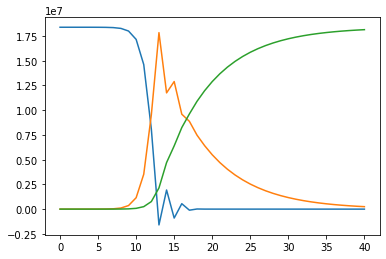

In [204]:
#initial state
initialDay = "2021-05-27"
#get recover number, include deaths
S = np.array(areaPopulation)
R = np.array([0,0,0,0,0,0])
I = np.array([0,0,0,0,0,0])
response = rqs.get("https://ncov.vncdc.gov.vn/v1/vietnam/province-type?start_time="+"2019-05-01"+"&end_time="+initialDay).json()
response = response['rows']
for row in range(len(response)):
  provinceName = response[row]["tinh"]
  areaCode = areaCodeDictionary[provinceName]
  R[areaCode - 1] += response[row]["ca_khoi"]+response[row]["tu_vong"]
  I[areaCode - 1] += response[row]["so_ca"]
  if response[row]["so_ca"] < response[row]["ca_khoi"]+response[row]["tu_vong"]:
    print(response[row])
S = S - I
I = I - R
print("Initial State")
print("S:", S)
print("I:",I)
print("R:", R)
s = np.divide(S, areaPopulation)
i = np.divide(I, areaPopulation)
r = np.divide(R, areaPopulation)



#Graph:
#Vertice data: SIR table
#Edge weigth: flow_passenger

#spread_rate (number of infected contacts that becoming infected)
#https://blog.vinbigdata.org/tim-hieu-ve-mot-mo-hinh-du-bao-dich-covid-19-tu-vu-han/?fbclid=IwAR3c5YWqwc6u3KjYj5u0mQP5arDrN52EXgOF2ihTqe1zJ96zMQo-9twG53s
spreadRate = 2.3
#With our calculating, 
#       the spread rate of covid 19 in Vietnam from 2019 to 2021-07-05 is 2.3,
#       but for credit purpose, we use 2.68

#infected time is average in 14 day
#https://thuvienphapluat.vn/van-ban/The-thao-Y-te/Quyet-dinh-1125-QD-BYT-2021-cham-soc-nguoi-benh-viem-duong-ho-hap-cap-do-vi-rut-SARS-CoV-2-464962.aspx
#7 day to become severe illness, and 7 more day to recover
#recover_rate (number of infected become recovered or death)
recoverRate = 1/7

Ss = np.array([S])
Is = np.array([I])
Rs = np.array([R])
#for everyday calculate the change of SIR status in each region
sdate = date(2021, 5, 27)   # start date
edate = date(2021, 7, 5)   # end date
delta = edate - sdate       # as timedelta
for i in range(delta.days + 1):
  day = sdate + timedelta(days=i)
  #transmit passengers
  for area_iter1 in range(5):
    for area_iter2 in range(area_iter1+1, 6):
      #probability of 1 people leaves the region area_iter1 and come to region area_iter2
      onePersonProb = (flow_passenger[area_iter1, area_iter2]/2)/areaPopulation[area_iter1]
      #count number leave region 1 and come to region 2
      countILeave = np.random.binomial(I[area_iter1], onePersonProb)
      countRLeave = np.random.binomial(R[area_iter1], onePersonProb)
      #probability of 1 people leaves the region area_iter2 and come to region area_iter1
      onePersonProb = (flow_passenger[area_iter1, area_iter2]/2)/areaPopulation[area_iter2]
      #count number come to region 1 from region 2
      countICome = np.random.binomial(I[area_iter2], onePersonProb)
      countRCome = np.random.binomial(R[area_iter2], onePersonProb)
      #arrived
      I[area_iter1] += countICome - countILeave
      I[area_iter2] += countILeave - countICome
      R[area_iter1] += countRCome - countRLeave
      R[area_iter2] += countRLeave - countRCome
      S[area_iter1] = areaPopulation[area_iter1] - I[area_iter1] - R[area_iter1]
      S[area_iter2] = areaPopulation[area_iter2] - I[area_iter2] - R[area_iter2]
  #SIR evolution
  #for each region
  for area in range(6):
    newInfected = spreadRate * S[area] / areaPopulation[area] * I[area]
    recovered = recoverRate * I[area]
    #update
    R[area] += recovered
    I[area] += newInfected - recovered
    S[area] = areaPopulation[area] - I[area] - R[area]
  #print(S)
  Ss = np.insert(Ss, len(Ss), S, axis=0)
  Is = np.insert(Is, len(Is), I, axis=0)
  Rs = np.insert(Rs, len(Rs), R, axis=0)
  #Ss = np.append(Ss, S)
print(I)
plt.plot(range((edate - sdate).days + 1+1),Ss[:,4])
plt.plot(range((edate - sdate).days + 1+1),Is[:,4])
plt.plot(range((edate - sdate).days + 1+1),Rs[:,4])
plt.show()


Initial State
S: [35653810 11008170  9350711  5939255 18390641 17290895]
I: [871  10  23   0   7  48]
R: [2839   56  950    0  460  198]
[22842462  3199054  4671188   138788  3165982  9228807]


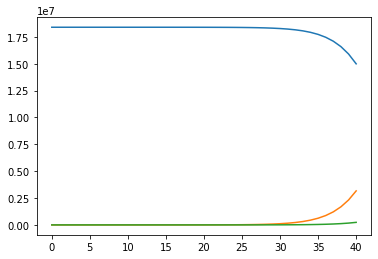

In [203]:
#initial state
initialDay = "2021-05-27"
#get recover number, include deaths
S = np.array(areaPopulation)
R = np.array([0,0,0,0,0,0])
I = np.array([0,0,0,0,0,0])
response = rqs.get("https://ncov.vncdc.gov.vn/v1/vietnam/province-type?start_time="+"2019-05-01"+"&end_time="+initialDay).json()
response = response['rows']
for row in range(len(response)):
  provinceName = response[row]["tinh"]
  areaCode = areaCodeDictionary[provinceName]
  R[areaCode - 1] += response[row]["ca_khoi"]+response[row]["tu_vong"]
  I[areaCode - 1] += response[row]["so_ca"]
  if response[row]["so_ca"] < response[row]["ca_khoi"]+response[row]["tu_vong"]:
    print(response[row])
S = S - I
I = I - R
print("Initial State")
print("S:", S)
print("I:",I)
print("R:", R)
s = np.divide(S, areaPopulation)
i = np.divide(I, areaPopulation)
r = np.divide(R, areaPopulation)

#Graph:
#Vertice data: SIR table
#Edge weigth: flow_passenger

#spread_rate (number of infected contacts that becoming infected)
#https://blog.vinbigdata.org/tim-hieu-ve-mot-mo-hinh-du-bao-dich-covid-19-tu-vu-han/?fbclid=IwAR3c5YWqwc6u3KjYj5u0mQP5arDrN52EXgOF2ihTqe1zJ96zMQo-9twG53s
spreadRate = 2.3
#With our calculating, 
#       the spread rate of covid 19 in Vietnam from 2019 to 2021-07-05 is 2.3,
#       but for credit purpose, we use 2.68

#infected time is average in 14 day
#https://thuvienphapluat.vn/van-ban/The-thao-Y-te/Quyet-dinh-1125-QD-BYT-2021-cham-soc-nguoi-benh-viem-duong-ho-hap-cap-do-vi-rut-SARS-CoV-2-464962.aspx
#7 day to become severe illness, and 7 more day to recover
#recover_rate (number of infected become recovered or death)
recoverRate = 1/7

#time that a infected begin spread
beginSpread = 5

Ss = np.array([S])
Is = np.array([I])
Rs = np.array([R])
#for everyday calculate the change of SIR status in each region
sdate = date(2021, 5, 27)   # start date
edate = date(2021, 7, 5)   # end date
delta = edate - sdate       # as timedelta
for i in range(delta.days + 1):
  day = sdate + timedelta(days=i)
  #transmit passengers
  for area_iter1 in range(5):
    for area_iter2 in range(area_iter1+1, 6):
      #probability of 1 people leaves the region area_iter1 and come to region area_iter2
      onePersonProb = (flow_passenger[area_iter1, area_iter2]/2)/areaPopulation[area_iter1]
      #count number leave region 1 and come to region 2
      countILeave = np.random.binomial(I[area_iter1], onePersonProb)
      countRLeave = np.random.binomial(R[area_iter1], onePersonProb)
      #probability of 1 people leaves the region area_iter2 and come to region area_iter1
      onePersonProb = (flow_passenger[area_iter1, area_iter2]/2)/areaPopulation[area_iter2]
      #count number come to region 1 from region 2
      countICome = np.random.binomial(I[area_iter2], onePersonProb)
      countRCome = np.random.binomial(R[area_iter2], onePersonProb)
      #arrived
      I[area_iter1] += countICome - countILeave
      I[area_iter2] += countILeave - countICome
      R[area_iter1] += countRCome - countRLeave
      R[area_iter2] += countRLeave - countRCome
      S[area_iter1] = areaPopulation[area_iter1] - I[area_iter1] - R[area_iter1]
      S[area_iter2] = areaPopulation[area_iter2] - I[area_iter2] - R[area_iter2]
  #SIR evolution
  #for each region
  for area in range(6):
    if i < 5:
      newInfected = 0
      recovered = 0
    else:
      newInfected = spreadRate * S[area] / areaPopulation[area] * Is[i-5,area]
      recovered = recoverRate * Is[i-5, area]
    #update
    R[area] += recovered
    I[area] += newInfected - recovered
    S[area] = areaPopulation[area] - I[area] - R[area]
  #add to trace of SIR through time
  Ss = np.insert(Ss, len(Ss), S, axis=0)
  Is = np.insert(Is, len(Is), I, axis=0)
  Rs = np.insert(Rs, len(Rs), R, axis=0)
print(I)
plt.plot(range((edate - sdate).days + 1+1),Ss[:,4])
plt.plot(range((edate - sdate).days + 1+1),Is[:,4])
plt.plot(range((edate - sdate).days + 1+1),Rs[:,4])
plt.show()

Initial State
S: [35653810 11008170  9350711  5939255 18390641 17290895]
I: [871  10  23   0   7  48]
R: [2839   56  950    0  460  198]
[28557673  3675532  5272794   236437  3844810 10207637]


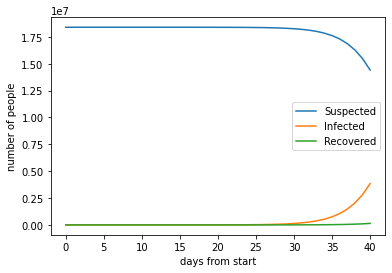

In [207]:
#initial state
initialDay = "2021-05-27"
#get recover number, include deaths
S = np.array(areaPopulation)
R = np.array([0,0,0,0,0,0])
I = np.array([0,0,0,0,0,0])
response = rqs.get("https://ncov.vncdc.gov.vn/v1/vietnam/province-type?start_time="+"2019-05-01"+"&end_time="+initialDay).json()
response = response['rows']
for row in range(len(response)):
  provinceName = response[row]["tinh"]
  areaCode = areaCodeDictionary[provinceName]
  R[areaCode - 1] += response[row]["ca_khoi"]+response[row]["tu_vong"]
  I[areaCode - 1] += response[row]["so_ca"]
  if response[row]["so_ca"] < response[row]["ca_khoi"]+response[row]["tu_vong"]:
    print(response[row])
S = S - I
I = I - R
print("Initial State")
print("S:", S)
print("I:",I)
print("R:", R)

#Graph:
#Vertice data: SIR table
#Edge weigth: flow_passenger

#spread_rate (number of infected contacts that becoming infected)
#https://blog.vinbigdata.org/tim-hieu-ve-mot-mo-hinh-du-bao-dich-covid-19-tu-vu-han/?fbclid=IwAR3c5YWqwc6u3KjYj5u0mQP5arDrN52EXgOF2ihTqe1zJ96zMQo-9twG53s
spreadRate = 2.3
#With our calculating, 
#       the spread rate of covid 19 in Vietnam from 2019 to 2021-07-05 is 2.3,
#       but for credit purpose, we use 2.68

#infected time is average in 14 day
#https://thuvienphapluat.vn/van-ban/The-thao-Y-te/Quyet-dinh-1125-QD-BYT-2021-cham-soc-nguoi-benh-viem-duong-ho-hap-cap-do-vi-rut-SARS-CoV-2-464962.aspx
#7 day to become severe illness, and 7 more day to recover
#recover_rate (number of infected become recovered or death)
recoverRate = 1/14

#time that a infected begin spread
beginSpread = 5

Ss = np.array([S])
Is = np.array([I])
Rs = np.array([R])
#for everyday calculate the change of SIR status in each region
sdate = date(2021, 5, 27)   # start date
edate = date(2021, 7, 5)   # end date
delta = edate - sdate       # as timedelta
for i in range(delta.days + 1):
  day = sdate + timedelta(days=i)
  #transmit passengers
  for area_iter1 in range(5):
    for area_iter2 in range(area_iter1+1, 6):
      #probability of 1 people leaves the region area_iter1 and come to region area_iter2
      onePersonProb = (flow_passenger[area_iter1, area_iter2]/2)/areaPopulation[area_iter1]
      #count number leave region 1 and come to region 2
      countILeave = np.random.binomial(I[area_iter1], onePersonProb)
      countRLeave = np.random.binomial(R[area_iter1], onePersonProb)
      #probability of 1 people leaves the region area_iter2 and come to region area_iter1
      onePersonProb = (flow_passenger[area_iter1, area_iter2]/2)/areaPopulation[area_iter2]
      #count number come to region 1 from region 2
      countICome = np.random.binomial(I[area_iter2], onePersonProb)
      countRCome = np.random.binomial(R[area_iter2], onePersonProb)
      #arrived
      I[area_iter1] += countICome - countILeave
      I[area_iter2] += countILeave - countICome
      R[area_iter1] += countRCome - countRLeave
      R[area_iter2] += countRLeave - countRCome
      S[area_iter1] = areaPopulation[area_iter1] - I[area_iter1] - R[area_iter1]
      S[area_iter2] = areaPopulation[area_iter2] - I[area_iter2] - R[area_iter2]
  #SIR evolution
  #for each region
  for area in range(6):
    if i < 5:
      newInfected = 0
      recovered = 0
    else:
      newInfected = spreadRate * S[area] / areaPopulation[area] * Is[i-5,area]
      recovered = recoverRate * Is[i-5, area]
    #update
    R[area] += recovered
    I[area] += newInfected - recovered
    S[area] = areaPopulation[area] - I[area] - R[area]
  #add to trace of SIR through time
  Ss = np.insert(Ss, len(Ss), S, axis=0)
  Is = np.insert(Is, len(Is), I, axis=0)
  Rs = np.insert(Rs, len(Rs), R, axis=0)
print(I)
plt.plot(range((edate - sdate).days + 1+1),Ss[:,4], label="Suspected")
plt.plot(range((edate - sdate).days + 1+1),Is[:,4], label="Infected")
plt.plot(range((edate - sdate).days + 1+1),Rs[:,4], label="Recovered")
plt.xlabel("days from start")
plt.ylabel("number of people")
plt.legend()
plt.show()

Initial State
S: [35653810 11008170  9350711  5939255 18390641 17290895]
I: [871  10  23   0   7  48]
R: [2839   56  950    0  460  198]
[9274817 4713773 3611696 3805998 8677925 6622473]


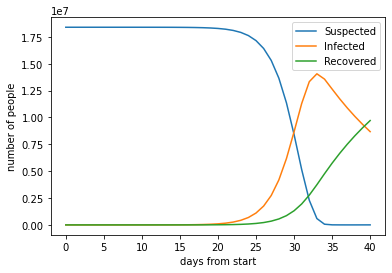

In [215]:
#initial state
initialDay = "2021-05-27"
#get recover number, include deaths
S = np.array(areaPopulation)
R = np.array([0,0,0,0,0,0])
I = np.array([0,0,0,0,0,0])
response = rqs.get("https://ncov.vncdc.gov.vn/v1/vietnam/province-type?start_time="+"2019-05-01"+"&end_time="+initialDay).json()
response = response['rows']
for row in range(len(response)):
  provinceName = response[row]["tinh"]
  areaCode = areaCodeDictionary[provinceName]
  R[areaCode - 1] += response[row]["ca_khoi"]+response[row]["tu_vong"]
  I[areaCode - 1] += response[row]["so_ca"]
  if response[row]["so_ca"] < response[row]["ca_khoi"]+response[row]["tu_vong"]:
    print(response[row])
S = S - I
I = I - R
print("Initial State")
print("S:", S)
print("I:",I)
print("R:", R)

#Graph:
#Vertice data: SIR table
#Edge weigth: flow_passenger

#spread_rate (number of infected contacts that becoming infected)
#https://blog.vinbigdata.org/tim-hieu-ve-mot-mo-hinh-du-bao-dich-covid-19-tu-vu-han/?fbclid=IwAR3c5YWqwc6u3KjYj5u0mQP5arDrN52EXgOF2ihTqe1zJ96zMQo-9twG53s
spreadRate = 2.3
#With our calculating, 
#       the spread rate of covid 19 in Vietnam from 2019 to 2021-07-05 is 2.3,
#       but for credit purpose, we use 2.68

#Average day detect a person infected
detectDay = 5

#infected time is average in 14 day
#https://thuvienphapluat.vn/van-ban/The-thao-Y-te/Quyet-dinh-1125-QD-BYT-2021-cham-soc-nguoi-benh-viem-duong-ho-hap-cap-do-vi-rut-SARS-CoV-2-464962.aspx
#7 day to become severe illness, and 7 more day to recover
#recover_rate (number of infected become recovered or death)
recoverRate = 1/14

#time that a infected begin spread
beginSpread = 2

Ss = np.array([S])
Is = np.array([I])
Rs = np.array([R])
NewInfecteds = np.array([I])
#for everyday calculate the change of SIR status in each region
sdate = date(2021, 5, 27)   # start date
edate = date(2021, 7, 5)   # end date
delta = edate - sdate       # as timedelta
for i in range(delta.days + 1):
  day = sdate + timedelta(days=i)
  #transmit passengers
  for area_iter1 in range(5):
    for area_iter2 in range(area_iter1+1, 6):
      #probability of 1 people leaves the region area_iter1 and come to region area_iter2
      onePersonProb = (flow_passenger[area_iter1, area_iter2]/2)/areaPopulation[area_iter1]
      #count number leave region 1 and come to region 2
      if I[area_iter1] > 0:
        countILeave = np.random.binomial(I[area_iter1], onePersonProb)
      else:
        countILeave = 0
      countRLeave = np.random.binomial(R[area_iter1], onePersonProb)
      #probability of 1 people leaves the region area_iter2 and come to region area_iter1
      onePersonProb = (flow_passenger[area_iter1, area_iter2]/2)/areaPopulation[area_iter2]
      #count number come to region 1 from region 2
      if I[area_iter2] > 0:
        countICome = np.random.binomial(I[area_iter2], onePersonProb)
      else:
        countICome = 0
      countRCome = np.random.binomial(R[area_iter2], onePersonProb)
      #arrived
      I[area_iter1] += countICome - countILeave
      I[area_iter2] += countILeave - countICome
      R[area_iter1] += countRCome - countRLeave
      R[area_iter2] += countRLeave - countRCome
      S[area_iter1] = areaPopulation[area_iter1] - I[area_iter1] - R[area_iter1]
      S[area_iter2] = areaPopulation[area_iter2] - I[area_iter2] - R[area_iter2]
  #SIR evolution
  #for each region
  for area in range(6):
    if i < beginSpread:
      newInfected = 0
      recovered = 0
    elif i < detectDay:
      newInfected = spreadRate * S[area] / areaPopulation[area] * (Is[i-beginSpread, area])
      #newInfected = spreadRate * S[area] / areaPopulation[area] * Is[i-5,area]
      recovered = recoverRate * Is[i, area]
    else:
      newInfected = spreadRate * S[area] / areaPopulation[area] * (Is[i-beginSpread, area]-Is[i-detectDay, area])
      recovered = recoverRate * Is[i, area]
    #update
    R[area] += recovered
    I[area] += newInfected - recovered
    S[area] = areaPopulation[area] - I[area] - R[area]
  #add to trace of SIR through time
  Ss = np.insert(Ss, len(Ss), S, axis=0)
  Is = np.insert(Is, len(Is), I, axis=0)
  Rs = np.insert(Rs, len(Rs), R, axis=0)
print(S)
print(I)
plt.plot(range((edate - sdate).days + 1+1),Ss[:,4], label="Suspected")
plt.plot(range((edate - sdate).days + 1+1),Is[:,4], label="Infected")
plt.plot(range((edate - sdate).days + 1+1),Rs[:,4], label="Recovered")
plt.xlabel("days from start")
plt.ylabel("number of people")
plt.legend()
plt.show()

Initial State
S: [35653810 11008170  9350711  5939255 18390641 17290895]
I: [871  10  23   0   7  48]
R: [2839   56  950    0  460  198]
[[   871     10     23      0      7     48]
 [   870     11     23      0      7     48]
 [   870     12     22      1      8     46]
 [  1475     18     38      0     12     79]
 [  2034     25     53      0     18    109]
 [  2554     32     65      0     25    135]
 [  2830     37     72      0     28    149]
 [  3521     44     89      0     34    185]
 [  4557     56    115      0     47    240]
 [  5269     67    132      0     56    275]
 [  6031     76    150      0     66    312]
 [  7131     90    177      0     79    371]
 [  8483    112    211      1     96    438]
 [  9792    130    244      0    118    503]
 [ 11049    152    277      1    137    570]
 [ 12711    180    317      2    163    653]
 [ 14677    211    368      1    194    751]
 [ 16622    243    418      2    231    849]
 [ 18662    283    470      3    271    950]
 [ 21056

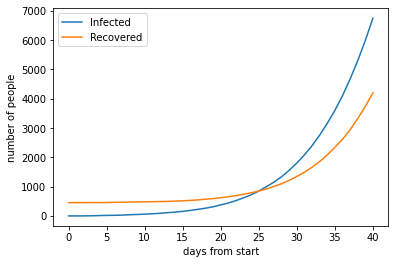

In [219]:
#initial state
initialDay = "2021-05-27"
#get recover number, include deaths
S = np.array(areaPopulation)
R = np.array([0,0,0,0,0,0])
I = np.array([0,0,0,0,0,0])
response = rqs.get("https://ncov.vncdc.gov.vn/v1/vietnam/province-type?start_time="+"2019-05-01"+"&end_time="+initialDay).json()
response = response['rows']
for row in range(len(response)):
  provinceName = response[row]["tinh"]
  areaCode = areaCodeDictionary[provinceName]
  R[areaCode - 1] += response[row]["ca_khoi"]+response[row]["tu_vong"]
  I[areaCode - 1] += response[row]["so_ca"]
  if response[row]["so_ca"] < response[row]["ca_khoi"]+response[row]["tu_vong"]:
    print(response[row])
S = S - I
I = I - R
print("Initial State")
print("S:", S)
print("I:",I)
print("R:", R)

#Graph:
#Vertice data: SIR table
#Edge weigth: flow_passenger


#time that a infected begin spread
beginSpread = 2

#Average day detect a person infected
detectDay = 5

#spread_rate (number of infected contacts that becoming infected)
#https://blog.vinbigdata.org/tim-hieu-ve-mot-mo-hinh-du-bao-dich-covid-19-tu-vu-han/?fbclid=IwAR3c5YWqwc6u3KjYj5u0mQP5arDrN52EXgOF2ihTqe1zJ96zMQo-9twG53s
spreadRate = 2.3/(detectDay - beginSpread)
#With our calculating, 
#       the spread rate of covid 19 in Vietnam from 2019 to 2021-07-05 is 2.3,
#       but for credit purpose, we use 2.68

#infected time is average in 14 day
#https://thuvienphapluat.vn/van-ban/The-thao-Y-te/Quyet-dinh-1125-QD-BYT-2021-cham-soc-nguoi-benh-viem-duong-ho-hap-cap-do-vi-rut-SARS-CoV-2-464962.aspx
#7 day to become severe illness, and 7 more day to recover
#recover_rate (number of infected become recovered or death)
recoverRate = 1/14

Ss = np.array([S])
Is = np.array([I])
Rs = np.array([R])
NewInfecteds = np.array([I])
#for everyday calculate the change of SIR status in each region
sdate = date(2021, 5, 27)   # start date
edate = date(2021, 7, 5)   # end date
delta = edate - sdate       # as timedelta
for i in range(delta.days + 1):
  day = sdate + timedelta(days=i)
  #transmit passengers
  for area_iter1 in range(5):
    for area_iter2 in range(area_iter1+1, 6):
      #probability of 1 people leaves the region area_iter1 and come to region area_iter2
      onePersonProb = (flow_passenger[area_iter1, area_iter2]/2)/areaPopulation[area_iter1]
      #count number leave region 1 and come to region 2
      if I[area_iter1] > 0:
        countILeave = np.random.binomial(I[area_iter1], onePersonProb)
      else:
        countILeave = 0
      countRLeave = np.random.binomial(R[area_iter1], onePersonProb)
      #probability of 1 people leaves the region area_iter2 and come to region area_iter1
      onePersonProb = (flow_passenger[area_iter1, area_iter2]/2)/areaPopulation[area_iter2]
      #count number come to region 1 from region 2
      if I[area_iter2] > 0:
        countICome = np.random.binomial(I[area_iter2], onePersonProb)
      else:
        countICome = 0
      countRCome = np.random.binomial(R[area_iter2], onePersonProb)
      #arrived
      I[area_iter1] += countICome - countILeave
      I[area_iter2] += countILeave - countICome
      R[area_iter1] += countRCome - countRLeave
      R[area_iter2] += countRLeave - countRCome
      S[area_iter1] = areaPopulation[area_iter1] - I[area_iter1] - R[area_iter1]
      S[area_iter2] = areaPopulation[area_iter2] - I[area_iter2] - R[area_iter2]
  #SIR evolution
  #for each region
  for area in range(6):
    if i < beginSpread:
      newInfected = 0
      recovered = 0
    elif i < detectDay:
      newInfected = spreadRate * S[area] / areaPopulation[area] * (Is[i-beginSpread, area])
      #newInfected = spreadRate * S[area] / areaPopulation[area] * Is[i-5,area]
      recovered = recoverRate * Is[i, area]
    else:
      newInfected = spreadRate * S[area] / areaPopulation[area] * (Is[i-beginSpread, area]-Is[i-detectDay, area])
      recovered = recoverRate * Is[i, area]
    #update
    R[area] += recovered
    I[area] += newInfected - recovered
    S[area] = areaPopulation[area] - I[area] - R[area]
  #add to trace of SIR through time
  Ss = np.insert(Ss, len(Ss), S, axis=0)
  Is = np.insert(Is, len(Is), I, axis=0)
  Rs = np.insert(Rs, len(Rs), R, axis=0)
print(Is)
#plt.plot(range((edate - sdate).days + 1+1),Ss[:,4], label="Suspected")
plt.plot(range((edate - sdate).days + 1+1),Is[:,4], label="Infected")
plt.plot(range((edate - sdate).days + 1+1),Rs[:,4], label="Recovered")
plt.xlabel("days from start")
plt.ylabel("number of people")
plt.legend()
plt.show()

Initial State
S: [35653810 11008170  9350711  5939255 18390641 17290895]
I: [871  10  23   0   7  48]
R: [2839   56  950    0  460  198]
[[ 871   10   23    0    7   48]
 [ 871   10   23    0    7   48]
 [ 870   11   23    0    7   48]
 [1098   17   38    0   11   81]
 [1105   24   51    0   16  112]
 [1113   30   65    0   19  140]
 [1056   33   71    0   20  155]
 [1003   40   87    1   26  191]
 [ 955   51  112    0   35  245]
 [ 886   58  130    0   42  281]
 [ 820   67  147    1   49  319]
 [ 761   78  172    0   58  375]
 [ 707   90  204    0   72  442]
 [ 656  105  234    0   84  508]
 [ 610  117  262    0   97  514]
 [ 563  135  300    0  114  530]
 [ 522  154  345    0  133  554]
 [ 483  172  389    0  156  558]
 [ 448  195  434    0  181  542]
 [ 418  218  486    0  204  519]
 [ 388  244  548    0  235  495]
 [ 361  271  550    0  271  464]
 [ 337  301  554    0  306  430]
 [ 315  332  566    0  344  399]
 [ 293  366  562    0  388  371]
 [ 274  402  542    0  441  342]
 [ 25

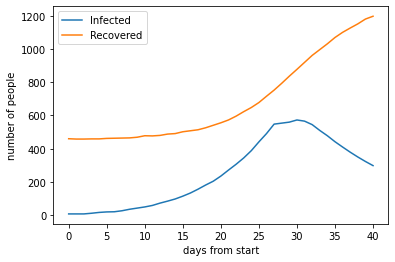

In [224]:
#initial state
initialDay = "2021-05-27"
#get recover number, include deaths
S = np.array(areaPopulation)
R = np.array([0,0,0,0,0,0])
I = np.array([0,0,0,0,0,0])
response = rqs.get("https://ncov.vncdc.gov.vn/v1/vietnam/province-type?start_time="+"2019-05-01"+"&end_time="+initialDay).json()
response = response['rows']
for row in range(len(response)):
  provinceName = response[row]["tinh"]
  areaCode = areaCodeDictionary[provinceName]
  R[areaCode - 1] += response[row]["ca_khoi"]+response[row]["tu_vong"]
  I[areaCode - 1] += response[row]["so_ca"]
  if response[row]["so_ca"] < response[row]["ca_khoi"]+response[row]["tu_vong"]:
    print(response[row])
S = S - I
I = I - R
print("Initial State")
print("S:", S)
print("I:",I)
print("R:", R)

#Graph:
#Vertice data: SIR table
#Edge weigth: flow_passenger

#time that a infected begin spread
beginSpread = 2

#Average day detect a person infected
detectDay = 5

#spread_rate (number of infected contacts that becoming infected)
#https://blog.vinbigdata.org/tim-hieu-ve-mot-mo-hinh-du-bao-dich-covid-19-tu-vu-han/?fbclid=IwAR3c5YWqwc6u3KjYj5u0mQP5arDrN52EXgOF2ihTqe1zJ96zMQo-9twG53s
commonSpreadRate = 2.3/(detectDay - beginSpread)
spreadRate = [commonSpreadRate] * 6
spreadRateScale = np.array([[500, 1], [1000, 0.3]])
#With our calculating, 
#       the spread rate of covid 19 in Vietnam from 2019 to 2021-07-05 is 2.3,
#       but for credit purpose, we use 2.68

#infected time is average in 14 day
#https://thuvienphapluat.vn/van-ban/The-thao-Y-te/Quyet-dinh-1125-QD-BYT-2021-cham-soc-nguoi-benh-viem-duong-ho-hap-cap-do-vi-rut-SARS-CoV-2-464962.aspx
#7 day to become severe illness, and 7 more day to recover
#recover_rate (number of infected become recovered or death)
recoverRate = 1/14

Ss = np.array([S])
Is = np.array([I])
Rs = np.array([R])
#NewInfecteds = np.array([I])
#for everyday calculate the change of SIR status in each region
sdate = date(2021, 5, 27)   # start date
edate = date(2021, 7, 5)   # end date
delta = edate - sdate       # as timedelta
for i in range(delta.days + 1):
  day = sdate + timedelta(days=i)
  #transmit passengers
  for area_iter1 in range(5):
    for area_iter2 in range(area_iter1 + 1, 6):
      #probability of 1 people leaves the region area_iter1 and come to region area_iter2
      onePersonProb = (flow_passenger[area_iter1, area_iter2]/2)/areaPopulation[area_iter1]
      #count number leave region 1 and come to region 2
      if I[area_iter1] > 0:
        countILeave = np.random.binomial(I[area_iter1], onePersonProb)
      else:
        countILeave = 0
      countRLeave = np.random.binomial(R[area_iter1], onePersonProb)
      #probability of 1 people leaves the region area_iter2 and come to region area_iter1
      onePersonProb = (flow_passenger[area_iter1, area_iter2]/2)/areaPopulation[area_iter2]
      #count number come to region 1 from region 2
      if I[area_iter2] > 0:
        countICome = np.random.binomial(I[area_iter2], onePersonProb)
      else:
        countICome = 0
      countRCome = np.random.binomial(R[area_iter2], onePersonProb)
      #arrived
      I[area_iter1] += countICome - countILeave
      I[area_iter2] += countILeave - countICome
      R[area_iter1] += countRCome - countRLeave
      R[area_iter2] += countRLeave - countRCome
      S[area_iter1] = areaPopulation[area_iter1] - I[area_iter1] - R[area_iter1]
      S[area_iter2] = areaPopulation[area_iter2] - I[area_iter2] - R[area_iter2]
  #SIR evolution
  #for each region
  for area in range(6):
    if i < beginSpread:
      newInfected = 0
      recovered = 0
    elif i < detectDay:
      newInfected = spreadRate[area] * S[area] / areaPopulation[area] * (Is[i-beginSpread, area])
      #newInfected = spreadRatS[area] / areaPopulation[area] * Is[i-5,area]
      recovered = recoverRate * Is[i, area]
    else:
      newInfected = spreadRate[area] * S[area] / areaPopulation[area] * (Is[i-beginSpread, area]-Is[i-detectDay, area])
      recovered = recoverRate * Is[i, area]
    if newInfected < 0:
      newInfected = 0
    if recovered < 0:
      recovered = 0
    #update
    R[area] += recovered
    I[area] += newInfected - recovered
    S[area] = areaPopulation[area] - I[area] - R[area]
    if I[area] > spreadRateScale[0, 0]:
      spreadRate[area] = spreadRateScale[0,1] / (detectDay - beginSpread)
    if I[area] > spreadRateScale[1, 0]:
      spreadRate[area] = spreadRateScale[1,1] / (detectDay - beginSpread)
  #add to trace of SIR through time
  Ss = np.insert(Ss, len(Ss), S, axis=0)
  Is = np.insert(Is, len(Is), I, axis=0)
  Rs = np.insert(Rs, len(Rs), R, axis=0)
print(Is)
#plt.plot(range((edate - sdate).days + 1+1),Ss[:,4], label="Suspected")
plt.plot(range((edate - sdate).days + 1+1),Is[:,4], label="Infected")
plt.plot(range((edate - sdate).days + 1+1),Rs[:,4], label="Recovered")
plt.xlabel("days from start")
plt.ylabel("number of people")
plt.legend()
plt.show()

[0.7666666666666666, 0.7666666666666666, 3, 0.7666666666666666, 1, 0.7666666666666666]
